In [3]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, log_loss
import kagglehub
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, callback
import tensorflow as tf

# general setting. do not change TEST_SIZE
RANDOM_SEED = 42
TEST_SIZE = 0.3

In [4]:
# load dataset（from kagglehub）
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
data = pd.read_csv(f"{path}/creditcard.csv")
data['Class'] = data['Class'].astype(int)

# prepare data
data = data.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [5]:
fraud = data[data['Class'] == 1]
nonfraud = data[data['Class'] == 0]
print(f'Fraudulent:{len(fraud)}, non-fraudulent:{len(nonfraud)}')
print(f'the positive class (frauds) percentage: {len(fraud)}/{len(fraud) + len(nonfraud)} ({len(fraud)/(len(fraud) + len(nonfraud))*100:.3f}%)')

Fraudulent:492, non-fraudulent:284315
the positive class (frauds) percentage: 492/284807 (0.173%)


In [70]:
from imblearn.over_sampling import SMOTE

# Extract features and labels
X = np.asarray(data.drop(columns=['Class']))
y = np.asarray(data['Class'])
# y = data['Class'].astype(int).values

# Split the dataset into training and testing sets (with stratification)
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

# PCA 降維
pca = PCA(n_components=25)  # 嘗試 2-20 的不同值
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

# SMOTE
# smote = SMOTE(
#     random_state=RANDOM_SEED,
#     sampling_strategy=0.17,
#     k_neighbors=3
#     )
# x_train, y_train = smote.fit_resample(x_train, y_train)

# Step 1: 用正常交易訓練 Isolation Forest
iso = IsolationForest(
    contamination=0.0017, #因為給予的資料都是正常交易，沒有詐欺交易，所以讓模型自己找異常的比例
    random_state=RANDOM_SEED,
    n_estimators=600,
    max_features=15,
    # max_samples=0.8,
    bootstrap=True
    )
iso.fit(x_train)

# Step 2: 用全部資料做預測（正常/異常）
iso_labels = iso.predict(x_train)
iso_labels = (iso_labels == -1).astype(int)  # -1 是異常，轉成 1

# Step 3: 合併 iso 標籤 與 原始 y_train 作為 LightGBM 訓練資料
# final_labels = np.where(y_train == 1, 1, iso_labels)  # 保留原本標記的詐欺，其餘用iso結果

x_train = np.hstack([x_train, iso_labels.reshape(-1, 1)])
iso_pred_test = iso.predict(x_test)
iso_feature_test = (iso_pred_test == -1).astype(int)
x_test = np.hstack((x_test, iso_feature_test.reshape(-1, 1)))

# Step 4: 訓練 LightGBM
# lgbm_model = lgb.LGBMClassifier(
#     n_estimators=200,
#     scale_pos_weight=9,
#     max_depth=5,
#     min_split_gain=0.0001,
#     min_data_in_leaf=30,
#     random_state=RANDOM_SEED,
#     verbose=0
#     )
# lgbm_model.fit(x_train, y_train)

# eval_set = [(x_train, y_train), (x_test, y_test)]

xg_model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=550,
    scale_pos_weight=6,
    # use_label_encoder=False,
    # eta=0.1,
    max_depth=7,
    random_state=RANDOM_SEED,
    # eval_metric='aucpr'
)

xg_model.fit(x_train, y_train)

# 儲存每一輪的 logloss
# evals_result = {}
# eval_set = [(x_train, y_train), (x_test, y_test)]

# xg_model.fit(
#     x_train, y_train,
#     # eval_set=[(x_train, 'train'), (x_test, 'eval')],
#     eval_set=eval_set,
#     # eval_metric='logloss',
#     verbose=False
# )

# evals_result = xg_model.evals_result()

# Step 5: 預測測試集
threshold = 0.4
y_proba = xg_model.predict_proba(x_test)[:, 1]  # 取得預測為正類（詐欺）的機率
y_pred = (y_proba > threshold).astype(int)
# y_pred = xg_model.predict(x_test)

In [71]:
def evaluation(y_true, y_pred, model_name="Model"):
   accuracy = accuracy_score(y_true, y_pred)
   precision = precision_score(y_true, y_pred, zero_division=0)
   recall = recall_score(y_true, y_pred)
   f1 = f1_score(y_true, y_pred)

   print(f'\n{model_name} Evaluation:')
   print('===' * 15)
   print('         Accuracy:', accuracy)
   print('  Precision Score:', precision)
   print('     Recall Score:', recall)
   print('         F1 Score:', f1)
   print("\nClassification Report:")
   print(classification_report(y_true, y_pred))

evaluation(y_test, y_pred, model_name="Hybrid Model")


Hybrid Model Evaluation:
         Accuracy: 0.9996957035684608
  Precision Score: 0.9365079365079365
     Recall Score: 0.8676470588235294
         F1 Score: 0.9007633587786259

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.94      0.87      0.90       136

    accuracy                           1.00     85443
   macro avg       0.97      0.93      0.95     85443
weighted avg       1.00      1.00      1.00     85443



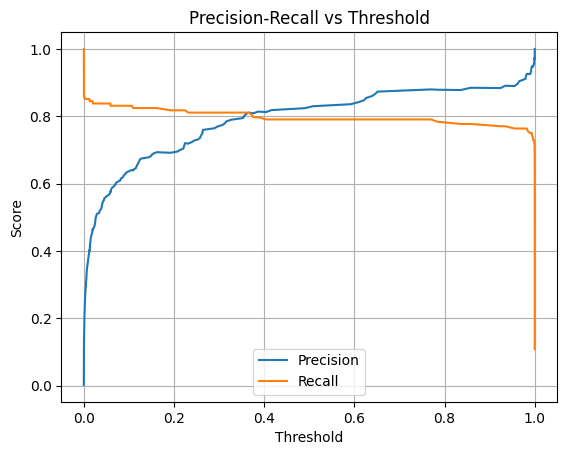

In [8]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_probs = xg_model.predict_proba(x_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.title('Precision-Recall vs Threshold')
plt.show()


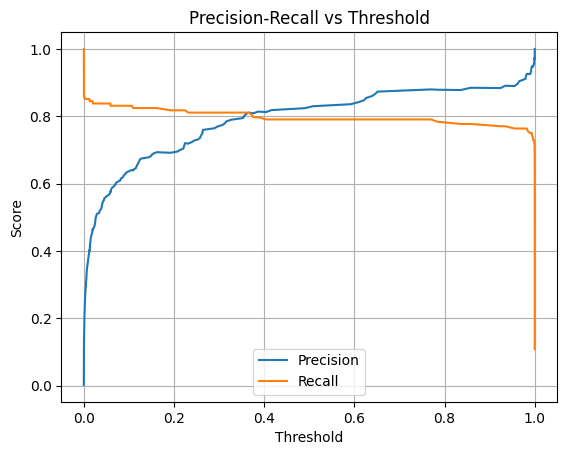

In [9]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()
